In [1]:
# ==========================
# 📦 Data Preprocessing: Unified Cell (Google Colab)
# ==========================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import os
import zipfile
import pandas as pd
import librosa

# Logging helper
def log(msg):
    print(f"[INFO] {msg}")

# Main preprocessing function
def extract_and_label_data_colab(ravdess_zip, cremad_zip, extract_root, save_path=None, preview=True):
    """
    Extracts audio files from ZIPs, parses emotion labels, performs cleaning,
    and returns a labeled DataFrame. Saves to CSV if path is provided.
    """

    # Setup directories
    ravdess_path = os.path.join(extract_root, "ravdess")
    cremad_path = os.path.join(extract_root, "cremad")
    os.makedirs(ravdess_path, exist_ok=True)
    os.makedirs(cremad_path, exist_ok=True)

    # Extract ZIP files
    log("Extracting RAVDESS...")
    with zipfile.ZipFile(ravdess_zip, 'r') as zip_ref:
        zip_ref.extractall(ravdess_path)

    log("Extracting CREMA-D...")
    with zipfile.ZipFile(cremad_zip, 'r') as zip_ref:
        zip_ref.extractall(cremad_path)

    target_emotions = ['happy', 'sad', 'neutral', 'angry']

    # Parse emotion from filename
    def parse_ravdess(filename):
        try:
            code = int(filename.split('-')[2])
            return {1: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry'}.get(code)
        except:
            return None

    def parse_cremad(filename):
        try:
            code = filename.split('_')[2]
            return {'ANG': 'angry', 'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'}.get(code)
        except:
            return None

    # Collect metadata
    ravdess_data = []
    for root, _, files in os.walk(ravdess_path):
        for file in files:
            if file.endswith('.wav'):
                emotion = parse_ravdess(file)
                full_path = os.path.join(root, file)
                if emotion in target_emotions:
                    ravdess_data.append({
                        'file_path': full_path,
                        'emotion': emotion,
                        'dataset': 'RAVDESS'
                    })

    cremad_data = []
    for root, _, files in os.walk(cremad_path):
        for file in files:
            if file.endswith('.wav'):
                emotion = parse_cremad(file)
                full_path = os.path.join(root, file)
                if emotion in target_emotions:
                    cremad_data.append({
                        'file_path': full_path,
                        'emotion': emotion,
                        'dataset': 'CREMA-D'
                    })

    df = pd.DataFrame(ravdess_data + cremad_data)
    log(f"Initial size: {df.shape}")

    # ========================
    # ✅ Data Cleaning
    # ========================

    # Drop nulls
    df.dropna(subset=['file_path', 'emotion'], inplace=True)

    # Remove missing or broken files
    df = df[df['file_path'].apply(lambda x: os.path.exists(x))]

    # Remove files < 1 sec (optional quality check)
    def is_valid_duration(path, min_sec=1.0):
        try:
            duration = librosa.get_duration(path=path)
            return duration >= min_sec
        except:
            return False

    df = df[df['file_path'].apply(is_valid_duration)]
    df.reset_index(drop=True, inplace=True)

    # Show stats
    if preview:
        log("✅ Sample rows:")
        print(df.head())
        log("📊 Emotion distribution:")
        print(df['emotion'].value_counts())
        log("📂 Dataset distribution:")
        print(df['dataset'].value_counts())

    # Save to CSV
    if save_path:
        df.to_csv(save_path, index=False)
        log(f"📁 Saved to: {save_path}")

    return df

# ================
# ✅ Run It
# ================
df = extract_and_label_data_colab(
    ravdess_zip="/content/drive/MyDrive/capstone_data/archive.zip",
    cremad_zip="/content/drive/MyDrive/capstone_data/crema.zip",
    extract_root="/content/dataset",
    save_path="/content/drive/MyDrive/capstone_data/combined_clean_metadata.csv",
    preview=True
)


Mounted at /content/drive
[INFO] Extracting RAVDESS...
[INFO] Extracting CREMA-D...
[INFO] Initial size: (6244, 3)
[INFO] ✅ Sample rows:
                                           file_path emotion  dataset
0  /content/dataset/ravdess/Actor_22/03-01-05-01-...   angry  RAVDESS
1  /content/dataset/ravdess/Actor_22/03-01-04-02-...     sad  RAVDESS
2  /content/dataset/ravdess/Actor_22/03-01-04-02-...     sad  RAVDESS
3  /content/dataset/ravdess/Actor_22/03-01-03-02-...   happy  RAVDESS
4  /content/dataset/ravdess/Actor_22/03-01-04-01-...     sad  RAVDESS
[INFO] 📊 Emotion distribution:
emotion
angry      1655
sad        1655
happy      1655
neutral    1279
Name: count, dtype: int64
[INFO] 📂 Dataset distribution:
dataset
CREMA-D    4900
RAVDESS    1344
Name: count, dtype: int64
[INFO] 📁 Saved to: /content/drive/MyDrive/capstone_data/combined_clean_metadata.csv


In [2]:
# ================================
# 🎯 Feature Extraction for XGBoost (Flattened MFCCs)
# ================================

# 📦 Imports
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.preprocessing import LabelEncoder
import joblib

# ✅ Config
METADATA_PATH = "/content/drive/MyDrive/capstone_data/combined_clean_metadata.csv"
X_SAVE_PATH = "/content/drive/MyDrive/capstone_data/x_xgb_features.npy"
Y_SAVE_PATH = "/content/drive/MyDrive/capstone_data/y_xgb_labels.npy"
ENCODER_PATH = "/content/drive/MyDrive/capstone_data/label_encoder.pkl"
MAX_PAD_LEN = 174  # ~4 seconds of audio

# ✅ Load metadata
df = pd.read_csv(METADATA_PATH)
print(f"[INFO] Loaded metadata: {df.shape[0]} rows")

# ✅ Feature extraction function
def extract_flat_mfcc(file_path, max_pad_len=174):
    try:
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc.flatten()
    except Exception as e:
        print(f"[WARN] Skipped file {file_path}: {e}")
        return None

# ✅ Extract features
X = []
y = []

for idx, row in df.iterrows():
    features = extract_flat_mfcc(row['file_path'], MAX_PAD_LEN)
    if features is not None:
        X.append(features)
        y.append(row['emotion'])

X = np.array(X)
y = np.array(y)

print(f"[INFO] Extracted features: X shape = {X.shape}, y shape = {y.shape}")

# ✅ Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ Save features and encoder
np.save(X_SAVE_PATH, X)
np.save(Y_SAVE_PATH, y_encoded)
joblib.dump(le, ENCODER_PATH)

print(f"[✅] Features saved to: {X_SAVE_PATH}")
print(f"[✅] Labels saved to: {Y_SAVE_PATH}")
print(f"[✅] Label encoder saved to: {ENCODER_PATH}")
print(f"[INFO] Classes: {le.classes_}")


[INFO] Loaded metadata: 6244 rows
[INFO] Extracted features: X shape = (6244, 6960), y shape = (6244,)
[✅] Features saved to: /content/drive/MyDrive/capstone_data/x_xgb_features.npy
[✅] Labels saved to: /content/drive/MyDrive/capstone_data/y_xgb_labels.npy
[✅] Label encoder saved to: /content/drive/MyDrive/capstone_data/label_encoder.pkl
[INFO] Classes: ['angry' 'happy' 'neutral' 'sad']


In [4]:
# ================================
# 🚀 Train XGBoost Model (Grid Search)
# ================================

# 📦 Imports
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

# ✅ Load Features and Labels
X = np.load("/content/drive/MyDrive/capstone_data/x_xgb_features.npy")
y = np.load("/content/drive/MyDrive/capstone_data/y_xgb_labels.npy")

print(f"[INFO] Loaded features: {X.shape}")
print(f"[INFO] Loaded labels: {y.shape}")

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb = XGBClassifier(max_depth=6, n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
joblib.dump(xgb, "/content/drive/MyDrive/capstone_data/xgb_model_quick.joblib")


[INFO] Loaded features: (6244, 6960)
[INFO] Loaded labels: (6244,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:40:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['/content/drive/MyDrive/capstone_data/xgb_model_quick.joblib']

In [5]:
# ================================
# 🚀 Train XGBoost Model (Final Version with Best Known Params)
# ================================

"""
This notebook trains the XGBoost model using the best hyperparameters
found previously through GridSearchCV:
  - max_depth = 8
  - n_estimators = 200
  - learning_rate = default (None)

To reduce training time in Google Colab (CPU-only), this version skips
GridSearch and directly trains with those final parameters.

Outputs:
- Trained model (`xgb_model.joblib`)
- Classification report
"""

# 📦 Imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib

# ✅ Load Features and Labels
X = np.load("/content/drive/MyDrive/capstone_data/x_xgb_features.npy")
y = np.load("/content/drive/MyDrive/capstone_data/y_xgb_labels.npy")

print(f"[INFO] Loaded X shape: {X.shape}")
print(f"[INFO] Loaded y shape: {y.shape}")

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Directly Train with Best Params
print("[INFO] Training with best-known parameters: max_depth=8, n_estimators=200")
xgb = XGBClassifier(
    max_depth=8,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# ✅ Evaluate
y_pred = xgb.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# ✅ Save Model
MODEL_PATH = "/content/drive/MyDrive/capstone_data/xgb_model.joblib"
joblib.dump(xgb, MODEL_PATH)
print(f"[✅] XGBoost model saved to: {MODEL_PATH}")


[INFO] Loaded X shape: (6244, 6960)
[INFO] Loaded y shape: (6244,)
[INFO] Training with best-known parameters: max_depth=8, n_estimators=200


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:45:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       331
           1       0.65      0.63      0.64       331
           2       0.62      0.63      0.63       256
           3       0.78      0.79      0.79       331

    accuracy                           0.71      1249
   macro avg       0.70      0.71      0.71      1249
weighted avg       0.71      0.71      0.71      1249

[✅] XGBoost model saved to: /content/drive/MyDrive/capstone_data/xgb_model.joblib


📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.77      0.77      0.77       331
       happy       0.65      0.63      0.64       331
     neutral       0.62      0.63      0.63       256
         sad       0.78      0.79      0.79       331

    accuracy                           0.71      1249
   macro avg       0.70      0.71      0.71      1249
weighted avg       0.71      0.71      0.71      1249



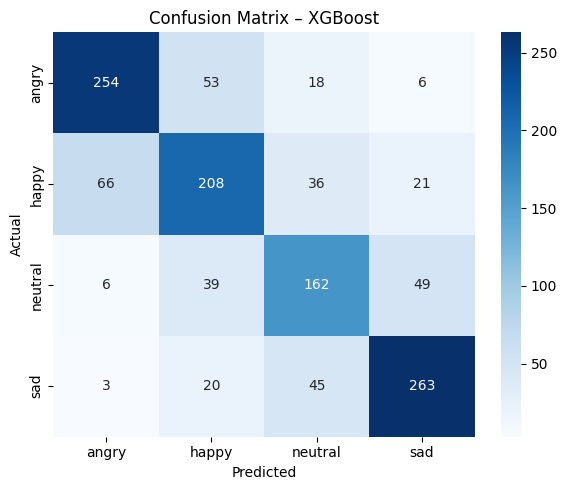

In [6]:
"""
Evaluate Trained XGBoost Model

This script:
- Loads saved XGBoost model, features, and labels
- Loads label encoder to decode predictions
- Evaluates performance on test set
- Displays classification report and confusion matrix


"""

# 📦 Imports
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# ✅ Paths
X_PATH = "/content/drive/MyDrive/capstone_data/x_xgb_features.npy"
Y_PATH = "/content/drive/MyDrive/capstone_data/y_xgb_labels.npy"
MODEL_PATH = "/content/drive/MyDrive/capstone_data/xgb_model.joblib"
ENCODER_PATH = "/content/drive/MyDrive/capstone_data/label_encoder.pkl"

# ✅ Load Data & Model
X = np.load(X_PATH)
y = np.load(Y_PATH)
model = joblib.load(MODEL_PATH)
label_encoder = joblib.load(ENCODER_PATH)

# ✅ Split (same as training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Predict
y_pred = model.predict(X_test)

# ✅ Decode labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_test)

# ✅ Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)

# ✅ Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Now Let's Start the CNN Procedures

In [7]:
# ================================
#  Feature Extraction for CNN (2D MFCCs)
# ================================

# 📦 Imports
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# ✅ Config
METADATA_PATH = "/content/drive/MyDrive/capstone_data/combined_clean_metadata.csv"
X_SAVE_PATH = "/content/drive/MyDrive/capstone_data/x_cnn_features.npy"
Y_SAVE_PATH = "/content/drive/MyDrive/capstone_data/y_cnn_labels.npy"
ENCODER_PATH = "/content/drive/MyDrive/capstone_data/label_encoder.pkl"
MAX_PAD_LEN = 174  # consistent with XGBoost for 4s audio

# ✅ Load Metadata
df = pd.read_csv(METADATA_PATH)
print(f"[INFO] Loaded metadata: {df.shape[0]} rows")

# ✅ Feature Extraction Function (2D MFCC)
def extract_mfcc_2d(file_path, max_pad_len=174):
    try:
        audio, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc[..., np.newaxis]  # shape: (40, max_pad_len, 1)
    except Exception as e:
        print(f"[WARN] Skipping {file_path}: {e}")
        return None

# ✅ Extract Features
X = []
y = []

for idx, row in df.iterrows():
    features = extract_mfcc_2d(row['file_path'], MAX_PAD_LEN)
    if features is not None:
        X.append(features)
        y.append(row['emotion'])

X = np.array(X)
y = np.array(y)
print(f"[INFO] Extracted: X shape = {X.shape}, y shape = {y.shape}")

# ✅ Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ Save Outputs
np.save(X_SAVE_PATH, X)
np.save(Y_SAVE_PATH, y_encoded)
joblib.dump(le, ENCODER_PATH)

print(f"[✅] Saved CNN features: {X_SAVE_PATH}")
print(f"[✅] Saved labels: {Y_SAVE_PATH}")
print(f"[✅] Label encoder: {ENCODER_PATH}")
print(f"[INFO] Classes: {le.classes_}")


[INFO] Loaded metadata: 6244 rows
[INFO] Extracted: X shape = (6244, 40, 174, 1), y shape = (6244,)
[✅] Saved CNN features: /content/drive/MyDrive/capstone_data/x_cnn_features.npy
[✅] Saved labels: /content/drive/MyDrive/capstone_data/y_cnn_labels.npy
[✅] Label encoder: /content/drive/MyDrive/capstone_data/label_encoder.pkl
[INFO] Classes: ['angry' 'happy' 'neutral' 'sad']


[INFO] X shape: (6244, 40, 174, 1), y shape: (6244,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771,972 (10.57 MB)

 Trainable params: 2,771,972 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.3102 - loss: 10.5365 - val_accuracy: 0.5020 - val_loss: 1.1639
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4605 - loss: 1.1372 - val_accuracy: 0.5316 - val_loss: 1.0085
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5168 - loss: 1.0632 - val_accuracy: 0.5821 - val_loss: 0.9635
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5511 - loss: 0.9967 - val_accuracy: 0.6021 - val_loss: 0.9269
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5550 - loss: 0.9640 - val_accuracy: 0.5909 - val_loss: 0.9413
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5942 - loss: 0.9236 - val_accuracy: 0.6213 - val_loss: 0.8848
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5995 - loss: 0.9172 - val_accuracy: 0.6357 - val_loss: 0.8628
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6255 - loss: 0.8612 - val_accu

[✅] CNN model saved to: /content/drive/MyDrive/capstone_data/cnn_model.h5


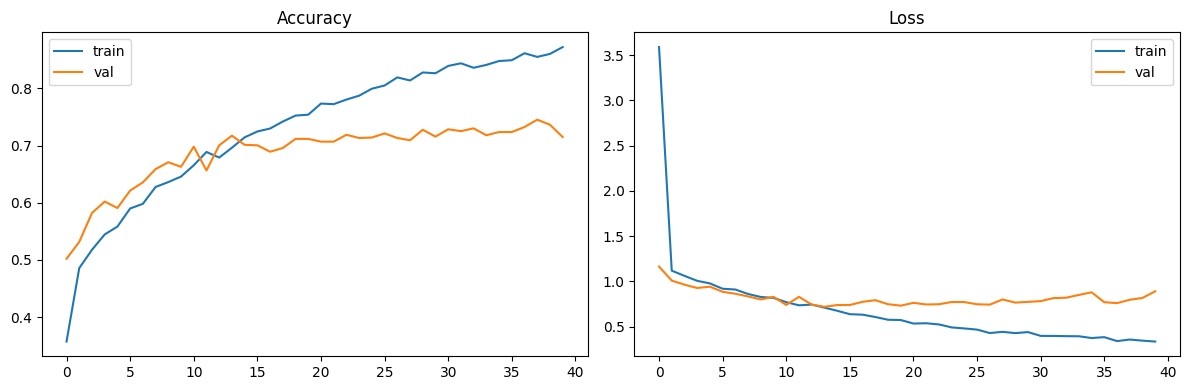

In [8]:
# ================================
# Train CNN Model for Emotion Detection
# ================================

"""
This notebook trains a Convolutional Neural Network (CNN) on 2D MFCC features
to classify emotions from voice input.

Inputs:
- x_cnn_features.npy
- y_cnn_labels.npy
- label_encoder.pkl

Outputs:
- cnn_model.h5
- Performance metrics


"""

# 📦 Imports
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt

# ✅ Paths
X_PATH = "/content/drive/MyDrive/capstone_data/x_cnn_features.npy"
Y_PATH = "/content/drive/MyDrive/capstone_data/y_cnn_labels.npy"
MODEL_PATH = "/content/drive/MyDrive/capstone_data/cnn_model.h5"

# ✅ Load Data
X = np.load(X_PATH)          # shape: (N, 40, 174, 1)
y = np.load(Y_PATH)          # integer labels
print(f"[INFO] X shape: {X.shape}, y shape: {y.shape}")

# ✅ One-hot Encode Labels
y_categorical = to_categorical(y, num_classes=len(np.unique(y)))

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

# ✅ CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 174, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# ✅ Train Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    verbose=1
)

# ✅ Save Model
model.save(MODEL_PATH)
print(f"[✅] CNN model saved to: {MODEL_PATH}")

# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.81      0.74      0.78       331
       happy       0.62      0.76      0.68       331
     neutral       0.59      0.68      0.63       256
         sad       0.89      0.67      0.76       331

    accuracy                           0.71      1249
   macro avg       0.73      0.71      0.71      1249
weighted avg       0.74      0.71      0.72      1249



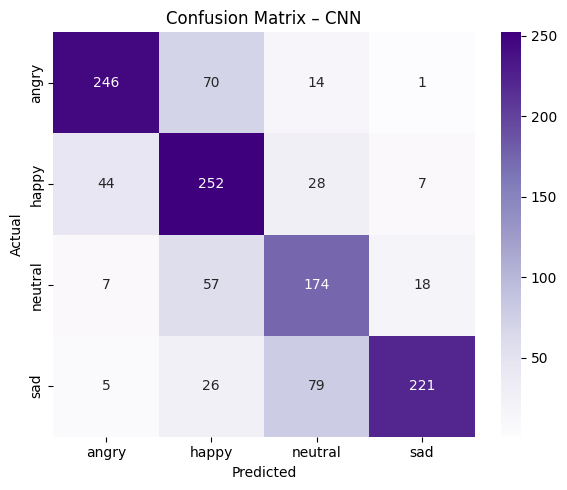

In [9]:
# ================================
#  Evaluate Trained CNN Model
# ================================

"""
This notebook:
- Loads the trained CNN model
- Loads test features and labels
- Decodes predictions using the saved label encoder
- Outputs confusion matrix and classification report


"""

# 📦 Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# ✅ Paths
X_PATH = "/content/drive/MyDrive/capstone_data/x_cnn_features.npy"
Y_PATH = "/content/drive/MyDrive/capstone_data/y_cnn_labels.npy"
MODEL_PATH = "/content/drive/MyDrive/capstone_data/cnn_model.h5"
ENCODER_PATH = "/content/drive/MyDrive/capstone_data/label_encoder.pkl"

# ✅ Load Data
X = np.load(X_PATH)
y = np.load(Y_PATH)
le = joblib.load(ENCODER_PATH)
model = load_model(MODEL_PATH)

# ✅ One-hot Encode for testing
y_categorical = to_categorical(y, num_classes=len(le.classes_))

# ✅ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42
)

# ✅ Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ Decode Labels
y_pred_labels = le.inverse_transform(y_pred)
y_true_labels = le.inverse_transform(y_true)

# ✅ Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – CNN")
plt.tight_layout()
plt.show()


In [10]:
# ================================
# Prediciton
# ================================

"""
This notebook:
- Lets you upload a .wav file
- Predicts emotion using XGBoost or CNN


Models must be pre-trained and saved:
- cnn_model.h5 or xgb_model.joblib
- label_encoder.pkl
"""

# 📦 Imports
import librosa
import numpy as np
import joblib
import tensorflow as tf
from google.colab import files
import openai

# ✅ Load files
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

# ✅ Paths
XGB_MODEL_PATH = "/content/drive/MyDrive/capstone_data/xgb_model.joblib"
CNN_MODEL_PATH = "/content/drive/MyDrive/capstone_data/cnn_model.h5"
ENCODER_PATH   = "/content/drive/MyDrive/capstone_data/label_encoder.pkl"

# ✅ Load models
xgb_model = joblib.load(XGB_MODEL_PATH)
cnn_model = tf.keras.models.load_model(CNN_MODEL_PATH)
label_encoder = joblib.load(ENCODER_PATH)

# ✅ Feature extraction for XGBoost
def extract_features_flat(file_path, max_pad_len=174):
    try:
        audio, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant') if pad_width > 0 else mfccs[:, :max_pad_len]
        return mfccs.flatten().reshape(1, -1)
    except Exception as e:
        print(f"[ERROR] XGB feature extraction failed: {e}")
        return None

# ✅ Feature extraction for CNN
def extract_features_2d(file_path, max_pad_len=174):
    try:
        audio, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant') if pad_width > 0 else mfccs[:, :max_pad_len]
        return mfccs[..., np.newaxis].reshape(1, 40, max_pad_len, 1)
    except Exception as e:
        print(f"[ERROR] CNN feature extraction failed: {e}")
        return None

# ✅ Predict emotion with both models
flat_feat = extract_features_flat(file_path)
cnn_feat  = extract_features_2d(file_path)

if flat_feat is not None:
    xgb_pred = xgb_model.predict(flat_feat)[0]
    xgb_emotion = label_encoder.inverse_transform([xgb_pred])[0]
    print(f"🎯 XGBoost Predicted Emotion: {xgb_emotion}")

if cnn_feat is not None:
    cnn_pred = np.argmax(cnn_model.predict(cnn_feat), axis=1)[0]
    cnn_emotion = label_encoder.inverse_transform([cnn_pred])[0]
    print(f"🤖 CNN Predicted Emotion: {cnn_emotion}")


Saving a13 (5).wav to a13 (5).wav
🎯 XGBoost Predicted Emotion: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
🤖 CNN Predicted Emotion: angry


In [6]:
pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.76.2
    Uninstalling openai-1.76.2:
      Successfully uninstalled openai-1.76.2


In [11]:
pip install streamlit streamlit-webrtc librosa scikit-learn xgboost speechrecognition pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.3/217.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 136.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing i

In [3]:
from pyngrok import ngrok

# Replace with ngrok token
ngrok.set_auth_token("key")

In [7]:
! pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
! streamlit run app.py & npx localtunnel --port 8501

34.125.108.33
⠙

⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.108.33:8501

⠴your url is: https://cool-years-greet.loca.lt
2025-05-08 21:49:27.932305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-08 21:49:27.952343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746740967.977646   29122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746740967.985412   29122 cuda_blas.cc:1418] Unable to register cuBL